In [1]:
%matplotlib inline

# Objective

The goal of this final section is to analyze the captured traffic data along the Van Wyck Expressway. 

We seek to know if it is possible to build a model that estimates traffic speed based on traffic camera images.


## Data Partitioning

Before we do the analysis, we will partition the data in order to account for a variety of lighting conditions.

Let's define the following partitions

* Nigthtime: By Camera ID and Weather Description
* Daytime - Non Clear Sky: By Camera ID and Weather Description
* Daytime - Clear Sky: By Hour of Day, Camera ID and Weather Description

Once we define our partitions, we will select a test partition and do a regression.


## Data Loading and Partitioning

In [2]:
import os
import pandas as pd

camera_data = pd.DataFrame().from_csv("camera_features.csv")
traffic_weather_data = pd.DataFrame().from_csv("traffic_and_weather_df.csv")


In [3]:
project_data = pd.merge(camera_data, traffic_weather_data, how='inner', on=['camera_id','timestamp'])
project_data['hour'] = project_data['hour'].astype(str)
project_data['camera_id'] = project_data['camera_id'].astype(str)
project_data['timestamp'] = project_data['timestamp'].astype(str)
project_data['location_id'] = project_data['location_id'].astype(str)

In [4]:
project_data.head()

,camera_id,filename,image_object_ct,image_object_ct_c,image_object_ct_l,image_object_ct_lr,image_object_ct_r,image_std,timestamp,location_id,travel_time,speed,location_name,speed_data_filename,hour,is_daytime,weather_data_filename,weather_description
0,589,1447258654_cctv589.jpg,7,10,10,24,17,0.086155,1447258654,426,121,57.17,VWE S MP4.63 (Exit 6 Jamaica Ave) - MP2.66 (Ex...,1447258654_speed_data.txt,11,True,1447258654_weather_data.json,Rain
1,594,1447258654_cctv594.jpg,5,12,12,13,6,0.050327,1447258654,427,857,9.94,VWE S MP6.39 (Exit 11 Jewel Ave) - MP4.63 (Exi...,1447258654_speed_data.txt,11,True,1447258654_weather_data.json,Rain
2,589,1447260454_cctv589.jpg,11,9,9,28,17,0.084551,1447260454,426,120,57.17,VWE S MP4.63 (Exit 6 Jamaica Ave) - MP2.66 (Ex...,1447260454_speed_data.txt,11,True,1447260454_weather_data.json,Rain
3,594,1447260454_cctv594.jpg,5,20,20,17,9,0.054599,1447260454,427,867,9.94,VWE S MP6.39 (Exit 11 Jewel Ave) - MP4.63 (Exi...,1447260454_speed_data.txt,11,True,1447260454_weather_data.json,Rain
4,594,1447262255_cctv594.jpg,5,29,29,27,7,0.054990,1447262255,427,829,9.94,VWE S MP6.39 (Exit 11 Jewel Ave) - MP4.63 (Exi...,1447262255_speed_data.txt,12,True,1447262255_weather_data.json,Clouds


In [5]:
project_data.describe()

,image_object_ct,image_object_ct_c,image_object_ct_l,image_object_ct_lr,image_object_ct_r,image_std,travel_time,speed,is_daytime
count,969.000000,969.000000,969.000000,969.000000,969.000000,967.000000,969.000000,969.000000,969
mean,13.372549,15.506708,15.506708,28.116615,17.525284,0.145679,356.613003,38.805418,0.435501
std,9.887305,10.535174,10.535174,14.601944,9.243360,0.056417,408.414845,16.878783,0.496078
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.017405,81.000000,3.730000,False
25%,6.000000,8.000000,8.000000,18.000000,11.000000,0.104464,134.000000,26.100000,0
50%,10.000000,12.000000,12.000000,24.000000,15.000000,0.137390,213.000000,44.740000,0
75%,18.000000,21.000000,21.000000,35.000000,21.000000,0.178892,300.000000,52.200000,1
max,68.000000,65.000000,65.000000,85.000000,70.000000,0.338472,2482.000000,62.760000,True


In [6]:
project_data.groupby('weather_description').count()


,camera_id,filename,image_object_ct,image_object_ct_c,image_object_ct_l,image_object_ct_lr,image_object_ct_r,image_std,timestamp,location_id,travel_time,speed,location_name,speed_data_filename,hour,is_daytime,weather_data_filename
weather_description,,,,,,,,,,,,,,,,,
Clear,749,749,749,749,749,749,749,748,749,749,749,749,749,749,749,749,749
Clouds,121,121,121,121,121,121,121,120,121,121,121,121,121,121,121,121,121
Mist,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
Rain,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90
Thunderstorm,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


Let's now define the partitions.

In [7]:
#project_data['partition'] = 

def partition_data(row):
    partition = ""
    if row['is_daytime'] and  row['weather_description'] == 'Clear':
        partition = 'H'+row[['hour','camera_id','weather_description']].str.cat(sep='_')
    elif row['is_daytime'] and  not(row['weather_description'] == 'Clear'):
        partition = 'DAY_'+row[['camera_id','weather_description']].str.cat(sep='_')
    elif not(row['is_daytime']):
        partition = 'NIGHT_'+row[['camera_id','weather_description']].str.cat(sep='_')
    else:
        partition = "Undefined partition... HELP!!!"
    return partition

project_data['partition']= project_data.apply(partition_data,axis=1)
project_data.head()

,camera_id,filename,image_object_ct,image_object_ct_c,image_object_ct_l,image_object_ct_lr,image_object_ct_r,image_std,timestamp,location_id,travel_time,speed,location_name,speed_data_filename,hour,is_daytime,weather_data_filename,weather_description,partition
0,589,1447258654_cctv589.jpg,7,10,10,24,17,0.086155,1447258654,426,121,57.17,VWE S MP4.63 (Exit 6 Jamaica Ave) - MP2.66 (Ex...,1447258654_speed_data.txt,11,True,1447258654_weather_data.json,Rain,DAY_589_Rain
1,594,1447258654_cctv594.jpg,5,12,12,13,6,0.050327,1447258654,427,857,9.94,VWE S MP6.39 (Exit 11 Jewel Ave) - MP4.63 (Exi...,1447258654_speed_data.txt,11,True,1447258654_weather_data.json,Rain,DAY_594_Rain
2,589,1447260454_cctv589.jpg,11,9,9,28,17,0.084551,1447260454,426,120,57.17,VWE S MP4.63 (Exit 6 Jamaica Ave) - MP2.66 (Ex...,1447260454_speed_data.txt,11,True,1447260454_weather_data.json,Rain,DAY_589_Rain
3,594,1447260454_cctv594.jpg,5,20,20,17,9,0.054599,1447260454,427,867,9.94,VWE S MP6.39 (Exit 11 Jewel Ave) - MP4.63 (Exi...,1447260454_speed_data.txt,11,True,1447260454_weather_data.json,Rain,DAY_594_Rain
4,594,1447262255_cctv594.jpg,5,29,29,27,7,0.054990,1447262255,427,829,9.94,VWE S MP6.39 (Exit 11 Jewel Ave) - MP4.63 (Exi...,1447262255_speed_data.txt,12,True,1447262255_weather_data.json,Clouds,DAY_594_Clouds


## Selecting Test Data

Now that we defined our partitions, we now will choose a partition to evaluate the feasability of modeling s=f(i), where s= road spee and i = image feature.

Selecting a good partition is not an obvious task. The Van Wyck Expressway is notorious for it's heavy traffic. There is no point on selecting the 5PM partition, we know that it will most certanly be moving at snail pace.

We want a partition that meets the following criteria:

* Has a good image sample size
* Has a high standard deviation of the road speed.

In [8]:
candidate_partitions = project_data.groupby('partition').count().sort_values(by='speed',ascending=False)['speed'].head()

candidate_partitions

partition
NIGHT_589_Clear    136
NIGHT_592_Clear    129
NIGHT_590_Clear    115
NIGHT_594_Clear     46
NIGHT_593_Clear     32
Name: speed, dtype: int64

From the above table, let's select our ideal partition based on the standard deviation of the road speed

In [9]:
candidate_partitions = candidate_partitions.index.values.tolist()

In [10]:
partitions = project_data.groupby('partition').std().sort_values(by='speed',ascending=False)['speed'].loc[candidate_partitions]
partitions


partition
NIGHT_589_Clear    11.436169
NIGHT_592_Clear    11.195258
NIGHT_590_Clear    19.090979
NIGHT_594_Clear    13.451157
NIGHT_593_Clear     9.719130
Name: speed, dtype: float64

As we can see above, our ideal candidate for this initial analysis is **NIGHT_590_Clear**

## Regression Analysis of NIGHT_590_Clear

Let's assess the correlation between the image features and the traffic speed:

In [11]:
import statsmodels.formula.api as sm
test_data = pd.DataFrame(project_data[project_data['partition']=='NIGHT_590_Clear'])

In [12]:
result = sm.ols(formula="speed ~ image_std+image_object_ct+image_object_ct_l+image_object_ct_r+image_object_ct_c+image_object_ct_lr", data=test_data).fit()
print result.params

Intercept             45.674325
image_std              2.709476
image_object_ct       -1.983286
image_object_ct_l      0.402466
image_object_ct_r      0.561381
image_object_ct_c      0.402466
image_object_ct_lr    -0.696174
dtype: float64


In [13]:
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     7.543
Date:                Thu, 03 Dec 2015   Prob (F-statistic):           4.08e-06
Time:                        10:55:49   Log-Likelihood:                -484.75
No. Observations:                 115   AIC:                             981.5
Df Residuals:                     109   BIC:                             998.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             45.6743      8

From the above results, we can see that the only statistically significant feature is the image_object_ct (with P<0.01). However, an R-squared of  **0.257** does not suggest a strong enough linear relationship to suggest that we can model **speed = $\alpha$ image_object_ct + $\beta$**. Let's see a scattered plot of the variables in question:

C:\Users\malarcon\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


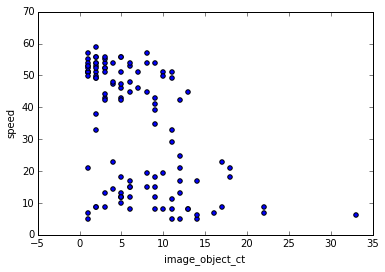

In [14]:
test_data[['speed','image_object_ct']].plot(kind='scatter', x='image_object_ct', y='speed')

If we notice the "triangular" shape that this scatter plot takes, perhaps we can try to define a probabilistic model such as **P(Congestion) = F(image_object_ct)**

## Modeling a Probability Distribution Function of Congestion by Logistic Regression

First, let's define the following features for the model:

* Congestion: Speed <= 30
* High Object Ct (7): image_object_ct >= 10

In [15]:
test_data['congestion'] = test_data['speed'] <= 30
test_data['image_object_ct_ge_10'] = test_data['image_object_ct'] >= 10


Let's now evaluate each these potential PDFs using the logit model:

In [16]:
speed_logit = sm.Logit(test_data['congestion'],test_data[['image_object_ct_ge_10']]).fit()
print speed_logit.summary()

Optimization terminated successfully.
         Current function value: 0.650290
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             congestion   No. Observations:                  115
Model:                          Logit   Df Residuals:                      114
Method:                           MLE   Df Model:                            0
Date:                Thu, 03 Dec 2015   Pseudo R-squ.:                 0.05014
Time:                        10:55:49   Log-Likelihood:                -74.783
converged:                       True   LL-Null:                       -78.731
                                        LLR p-value:                       nan
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
image_object_ct_ge_10     1.2321      0.430      2.868      0.004         0.390     2.

From the results above, we can see that an image_object_ct with more than 10 objects is positively correlated with traffic congestion with a P<0.05.

Let's see what the theoretical probabilities are and how they stack up to the observed probabilities.

In [17]:
speed_logit.predict(pd.DataFrame({'image_object_ct_ge_10' : pd.Series([True,False])}))

array([ 0.77419355,  0.5       ])

From the above predicted values, we can say that if the object count is greater than 10, the probability of traffic congestion is 77%. Otherwise, the probability of congestion is 50%

# Conclusion

It is possible to build some sort of statistical model that correlates traditional quantitative data such as traffic speed to algorithmically extracted features from unstructured data, images in particular.

Exploring more sophisticated feature extraction algorithms is a well-worth pursuit which should yield in data that can be used in a linear regression and other quantitative models.